In [1]:
import torch
import numpy as np
from diffusion import q_sample, posterior_q, Denoising, denoise_with_mu
from utils import pack_data, unpack_1d_data, scatter_pixels

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ATTENTION ##
###### Download this image https://www.infomoney.com.br/wp-content/uploads/2019/06/homer-simpson.jpg?resize=900%2C515&quality=50&strip=all and save it in this folder as 'homer.png'


In [44]:
# x,y = scatter_pixels('./homer.png')
import numpy as np 
x = np.random.random(100)
y = x ** 2 + np.random.random(100) * 0.1

## Scatter plot of data we will try to train the model to generate from random noise

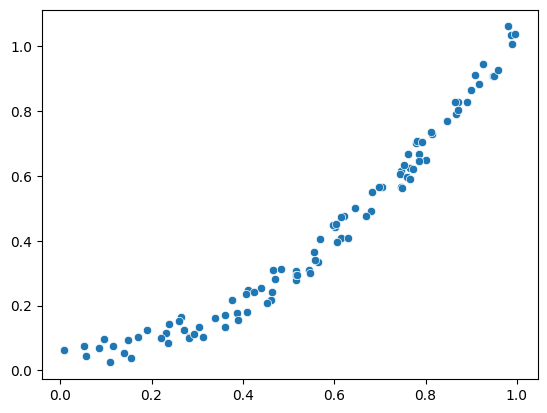

In [64]:
import seaborn as sns
data = (x, y)
ax = sns.scatterplot(x=x, y=y)

In [47]:
## Store the ax to plot the result later
y_ax = ax.get_ylim()
x_ax = ax.get_xlim()
axes = (x_ax,y_ax)

In [20]:
# send data to device
one_d_data = pack_data(x,y)
x_init = torch.tensor(one_d_data).to(torch.float32).to(device)

DATA_SIZE = len(x_init)


# Diffusion Parameters

In [65]:
beta_start = .00004
beta_end = .002
num_diffusion_timesteps = 100

In [66]:
from operator import mul
from functools import reduce 

betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps) ** 2
alphas = 1 - betas

# send parameters to device
betas = torch.tensor(betas).to(torch.float32).to(device)
alphas = torch.tensor(alphas).to(torch.float32).to(device)

# alpha_bar_t is the product of all alpha_ts from 0 to t
list_bar_alphas = [alphas[0]]
for t in range(1,num_diffusion_timesteps):
    list_bar_alphas.append(reduce(mul,alphas[:t]))
    
list_bar_alphas = torch.cumprod(alphas, axis=0).to(torch.float32).to(device)

## Training Procedure

In [67]:
import torch.nn as nn
import torch.optim as optim


training_steps_per_epoch = 40


criterion = nn.MSELoss()
denoising_model = Denoising(DATA_SIZE, num_diffusion_timesteps).to(device)
# disgusting hack to put embedding layer on 'device' as well, as it is not a pytorch module!
denoising_model.emb = denoising_model.emb.to(device)
optimizer = optim.AdamW(denoising_model.parameters())

In [68]:
from tqdm import tqdm

pbar = tqdm(range(20))
for epoch in pbar:  # loop over the dataset multiple times
    
    running_loss = 0.0
    # sample a bunch of timesteps
    Ts = np.random.randint(1,num_diffusion_timesteps, size=training_steps_per_epoch)
    for _, t in enumerate(Ts):
        # produce corrupted sample
        q_t = q_sample(x_init, t, list_bar_alphas, device)
                
        # calculate the mean and variance of the posterior forward distribution q(x_t-1 | x_t,x_0)
        mu_t, cov_t = posterior_q(x_init, q_t, t, alphas, list_bar_alphas, device)
        # get just first element from diagonal of covariance since they are all equal
        sigma_t = cov_t[0][0]
        # zero the parameter gradients
        optimizer.zero_grad()
  
        mu_theta = denoising_model(q_t , t)
        loss = criterion(mu_t, mu_theta)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach()
    pbar.set_description('Epoch: {} Loss: {}'.format(epoch, running_loss/training_steps_per_epoch))
print('Finished Training')

Epoch: 1 Loss: 0.054119013249874115:  10%|█         | 2/20 [00:40<06:07, 20.40s/it]

### Reserve-Diffuse one Sample of Noise!

In [62]:
from tqdm import tqdm 
data = torch.distributions.MultivariateNormal(loc=torch.zeros(DATA_SIZE),covariance_matrix=torch.eye(DATA_SIZE)).sample().to(device)

for t in tqdm(range(0,num_diffusion_timesteps)):
    data = denoise_with_mu(denoising_model,data,num_diffusion_timesteps-t-1, alphas, list_bar_alphas, DATA_SIZE, device)

100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


In [54]:
print(data)
# data = data.detach().cpu().numpy()
x_new, y_new = unpack_1d_data(data)

import seaborn as sns
sns.scatterplot(x=x_new,y=y_new)

(array([0.05702874, 0.61416908, 0.08525594, 0.05149226, 0.9808778 ,
       0.92464054, 0.56511543, 0.40854984, 0.9074799 , 0.70387498,
       0.3035275 , 0.51530015, 0.62247746, 0.94801959, 0.98778704,
       0.2651639 , 0.55712145, 0.33917704, 0.81363005, 0.98977775,
       0.28116274, 0.56879947, 0.74508644, 0.87164455, 0.4837664 ,
       0.18933689, 0.11662094, 0.16953319, 0.41176259, 0.26085136,
       0.6017302 , 0.09491126, 0.51613415, 0.23236512, 0.54462559,
       0.46149639, 0.68178263, 0.28255028, 0.68111634, 0.74685176,
       0.15442172, 0.27062912, 0.89960341, 0.86570599, 0.76621451,
       0.74429588, 0.60620277, 0.80169425, 0.38705495, 0.59634475,
       0.00894778, 0.99615312, 0.23502938, 0.36184051, 0.75884533,
       0.38972491, 0.54621019, 0.86418826, 0.74941535, 0.51639329,
       0.95083607, 0.10807391, 0.81207054, 0.7610744 , 0.36065281,
       0.60338244, 0.61394196, 0.67027977, 0.13912277, 0.37724431,
       0.43890256, 0.8910174 , 0.784969  , 0.46273672, 0.4710

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Create an AWESOME HD 24fps GIF

/var/folders/48/vt8rvxh55dx8lnxl2c0nn5dm0000gn/T/ipykernel_55726/1926754812.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.scatterplot(x=x_new,y=y_new,palette=['green'])
/var/folders/48/vt8rvxh55dx8lnxl2c0nn5dm0000gn/T/ipykernel_55726/1926754812.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.scatterplot(x=x_new,y=y_new,palette=['green'])
/var/folders/48/vt8rvxh55dx8lnxl2c0nn5dm0000gn/T/ipykernel_55726/1926754812.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.scatterplot(x=x_new,y=y_new,palette=['green'])
/var/folders/48/vt8rvxh55dx8lnxl2c0nn5dm0000gn/T/ipykernel_55726/1926754812.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.scatterplot(x=x_new,y=y_new,palette=['green'])
/var/folders/48/vt8rvxh55dx8lnxl2c0nn5dm0000gn/T/ipykernel_55726/1926754812.py:16: UserWarning: Ignoring `palette` b

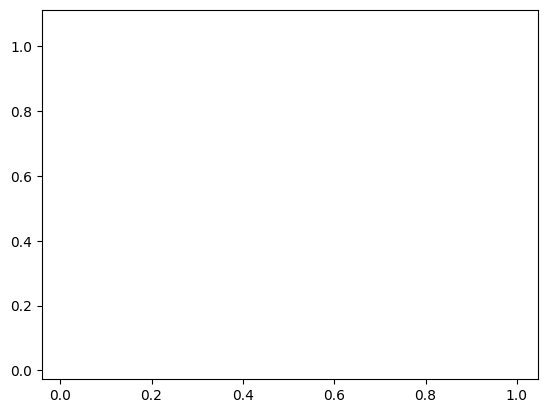

In [63]:
import numpy as np
from celluloid import Camera
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
camera = Camera(fig)

# animation draws one data point at a time
for d in range(1, num_diffusion_timesteps):
    data = denoise_with_mu(denoising_model,data,num_diffusion_timesteps-d, alphas, list_bar_alphas, DATA_SIZE, device)
    data_plot = data.detach().cpu().numpy()
    x_new, y_new = unpack_1d_data(data_plot)
    graph = sns.scatterplot(x=x_new,y=y_new,palette=['green'])
    graph.set_xlim(axes[0])
    graph.set_ylim(axes[1])
    camera.snap()

anim = camera.animate(blit=False)
anim.save('output.gif',fps=24, dpi=120)